In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 
import re
import datetime
import dateutil
from efunds import EFund
import collections as coll
import statsmodels.api as sm
%matplotlib inline

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
## eVestment Data Readin


InvUniverse_Name= ['USLargeCore', 'USLargeGrowth', 'USLargeValue']

# sample_period= '7817'

# # produce return series timestamp
# tmp_indx= []
# t= datetime.datetime( year= 1978, month= 1, day= 31)
# t= t+ dateutil.relativedelta.relativedelta( day= 31)
# tmp_indx.append( t)
# while t< datetime.datetime( year= 2017, month= 12, day=30):
#     t= t+ dateutil.relativedelta.relativedelta( months=1, day= 31)
#     tmp_indx.append( t)

# # read in data
# InvUniverse= dict()
# FundAttr_dict= dict()
# FundRet_dict= dict()
# USLaregeEquity_Index= set()
# for u in InvUniverse_Name:
#     a= pd.read_excel( io= 'eVestment/eV_'+ u+ '_'+sample_period+'.xlsx', 
#                      sheet_name= u+' General Info',
#                      index_col= None, na_values='---' ).dropna(how= 'all', axis=0)
#     a['eVestment Product ID']= a['eVestment Product ID'].astype(int).astype(str)
#     a.set_index('eVestment Product ID', inplace=True)
#     tmp_flag= [ re.match( 'Returns -', x) is not None for x in a.columns]
#     a_attr= a.loc[:, np.logical_not( tmp_flag)].transpose()
#     a_ret= a.loc[:, tmp_flag].transpose()/100
#     a_ret.index= tmp_indx
#     FundAttr_dict.update(a_attr.to_dict())
#     FundRet_dict.update( a_ret.to_dict())
#     a_indx= list(a_attr.loc[ :, a_attr.loc['VT', :]=='IX'].columns)
#     USLaregeEquity_Index= USLaregeEquity_Index.union(set( a_indx))
    
#     InvUniverse[u]= list(set(a_attr.columns)- set(a_indx))
#     InvUniverse[u+'_INDEX']= a_indx


# FundAttr= pd.DataFrame( FundAttr_dict)
# FundRet= pd.DataFrame(FundRet_dict)



# pickle.dump(FundAttr, open('FundAttr.p', 'wb'))
# pickle.dump(FundRet,  open('FundRet.p', 'wb'))
# pickle.dump(InvUniverse, open('InvUniverse.p', 'wb'))

FundAttr= pickle.load(open('FundAttr.p', 'rb'))
FundRet= pickle.load( open('FundRet.p', 'rb'))
InvUniverse= pickle.load( open( 'InvUniverse.p', 'rb'))


#### How many funds keeps reporting in each year? 



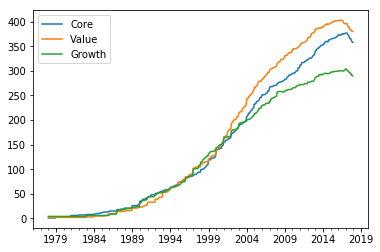

In [3]:
FundRet[InvUniverse['USLargeCore']].count(axis =1).plot(label= 'Core', )
FundRet[InvUniverse['USLargeValue']].count(axis=1).plot(label= 'Value', )
FundRet[InvUniverse['USLargeGrowth']].count(axis=1).plot(label= 'Growth', logy= False)
plt.legend()

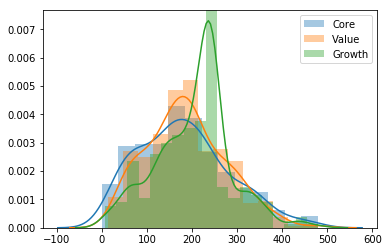

In [4]:
# FundRet[InvUniverse['USLargeCore']].count(axis=0).hist()

sns.distplot(FundRet[InvUniverse['USLargeCore']].count(axis=0), hist= True, label='Core')
sns.distplot(FundRet[InvUniverse['USLargeValue']].count(axis=0), hist= True, label= 'Value')
sns.distplot(FundRet[InvUniverse['USLargeGrowth']].count(axis=0),hist= True, label='Growth')
plt.legend()

In [5]:
INDX_raw= pickle.load(open('INDX_raw.p','rb'))
INDX_Ret= pd.concat( list({k: (x- x.shift(1))/x.shift(1) for k,x in INDX_raw.items()}.values()), axis=1) 
INDX_Ret['Value_Prem']= INDX_Ret['RU1000VTR']- INDX_Ret['RU1000TR']
INDX_Ret= INDX_Ret.loc[np.logical_and(INDX_Ret.index>= datetime.datetime(1985,1,1), 
                                      INDX_Ret.index<= datetime.datetime(2017, 10,1)), ]
FundRet= FundRet.loc[np.logical_and(  FundRet.index>= datetime.datetime(1985,1,1), 
                                      FundRet.index<= datetime.datetime(2017,10,1)), ]
INDX_EFunds= {'RU1000TR': EFund(EProdID='RU1000TR', ret= INDX_Ret['RU1000TR']),
             'RU1000VTR': EFund(EProdID='RU1000VTR', ret= INDX_Ret['RU1000VTR']),
             'RU1000GTR': EFund(EProdID='RU1000GTR', ret= INDX_Ret['RU1000GTR'])}
INDX_Ret['Bull']= INDX_Ret.RU1000TR>=0


#### Is it possible to map ConEd managers to certain group/family of funds in Evestment? 



In [6]:
eVFunds= {}
eVFundsRegs= {}
eVFundsRegs_Bull= {}
eVFundsRegs_Bear= {}

# for k, v in InvUniverse.items():
#     tmp = {}
#     regs= {}
#     for ID in v:
#         r= FundRet[ID]
#         if r.count()<10:
#             continue
#         a= EFund(EProdID=ID, ret=r, benchmark=INDX_EFunds['RU1000TR'])
#         if not(a.isMissing) and a.validRet.shape[0]>=10:
#             tmp[ID]= a
#             regs[ID]= sm.OLS(endog=a.validRet, exog= sm.add_constant(a.benchmarkRet)).fit()
    
#     EvFunds[k]= tmp
#     EvFunds_Stats[k]= regs
for ID in FundRet.columns:
    r= FundRet[ID]
    if r.count()<10:
        continue
    a= EFund( EProdID= ID, ret= r, benchmark= INDX_EFunds['RU1000VTR'])
    if not (a.isMissing):
        eVFunds[ID]= a
        ret= a.validRet.copy(deep=True)
        ret.name= ID+'_ret'
        d= sm.add_constant(pd.concat([ret, a.benchmarkRet, INDX_Ret[ 'Bull']], axis=1).dropna(how='any', axis=0))
        d1= d.loc[d.Bull, ]
        d2= d.loc[np.logical_not(d.Bull), ]
        eVFundsRegs[ID]= sm.OLS(endog= d[ret.name], exog= d.drop([ret.name, 'Bull'], axis=1), missing='drop').fit()
        if d1.shape[0]>=10:
            eVFundsRegs_Bull[ID]= sm.OLS(endog= d1[ret.name],  exog= d1.drop([ret.name, 'Bull'], axis=1), missing='drop').fit()
        if d2.shape[0]>=10:
            eVFundsRegs_Bear[ID]= sm.OLS(endog= d2[ret.name],  exog= d2.drop([ret.name, 'Bull'], axis=1), missing='drop').fit()
        

In [7]:
eVFunds_Type= {}
for k,v in InvUniverse.items():
    for ID in v:
        eVFunds_Type[ID]= k
eVFunds_beta0= {k:v.params for k, v in eVFundsRegs.items()}
eVFunds_beta1= {k:v.params for k, v in eVFundsRegs_Bull.items()}
eVFunds_beta2= {k:v.params for k, v in eVFundsRegs_Bear.items()}

eVFunds_pValue0= {k:v.pvalues for k,v in eVFundsRegs.items()}
eVFunds_pValue1= {k:v.pvalues for k,v in eVFundsRegs_Bull.items()}
eVFunds_pValue2= {k:v.pvalues for k,v in eVFundsRegs_Bear.items()}

eVFunds_nobs0= {k:v.nobs for k,v in eVFundsRegs.items()}
eVFunds_nobs1= {k:v.nobs for k,v in eVFundsRegs_Bull.items()}
eVFunds_nobs2= {k:v.nobs for k,v in eVFundsRegs_Bear.items()}


c= pd.Series(eVFunds_Type, name='Type')
eVFunds_0= pd.concat([pd.DataFrame(eVFunds_beta0).T, pd.Series(eVFunds_nobs0, name= 'NObs')], axis=1)
eVFunds_0['BenchmarkCond']= 'Overall'
eVFunds_0= pd.concat([eVFunds_0, c], axis=1).dropna(how='any', axis=0)
eVFunds_0.index.name= 'EProdID'
eVFunds_0.reset_index(inplace=True)

eVFunds_1= pd.concat([pd.DataFrame(eVFunds_beta1).T, pd.Series(eVFunds_nobs1, name= 'NObs')], axis=1)
eVFunds_1['BenchmarkCond']= 'Gain'
eVFunds_1= pd.concat([eVFunds_1, c], axis=1).dropna(how='any', axis=0)
eVFunds_1.index.name= 'EProdID'
eVFunds_1.reset_index(inplace=True)

eVFunds_2= pd.concat([pd.DataFrame(eVFunds_beta2).T, pd.Series(eVFunds_nobs2, name= 'NObs')], axis=1)
eVFunds_2['BenchmarkCond']= 'Loss'
eVFunds_2= pd.concat([eVFunds_2, c], axis=1).dropna(how='any', axis=0)
eVFunds_2.index.name= 'EProdID'
eVFunds_2.reset_index(inplace=True)

eVFunds_beta= pd.concat([eVFunds_0, eVFunds_1, eVFunds_2], axis=0)
eVFunds_beta.reset_index(drop=True, inplace=True)


# eVFunds_rsq= {k:v.rsquared for k,v in eVFundsRegs.items()}
eVFunds_IR= {k:v.IR for k, v in eVFunds.items()}
eVFunds_alpha= {k:v.alpha for k,v in eVFunds.items()}
eVFunds_te= {k:v.te for k,v in eVFunds.items()}


In [8]:
eVFunds_stats= pd.DataFrame([
                            pd.Series(eVFunds_IR, name= 'IR').astype(float),
                            pd.Series(eVFunds_alpha, name= 'Alpha').astype(float),
                            pd.Series(eVFunds_te, name='TE').astype(float)]).T

c= pd.Series(eVFunds_Type, name='Type')
eVFunds_stats= pd.concat([eVFunds_stats, c], axis=1).dropna(how='any', axis=0)



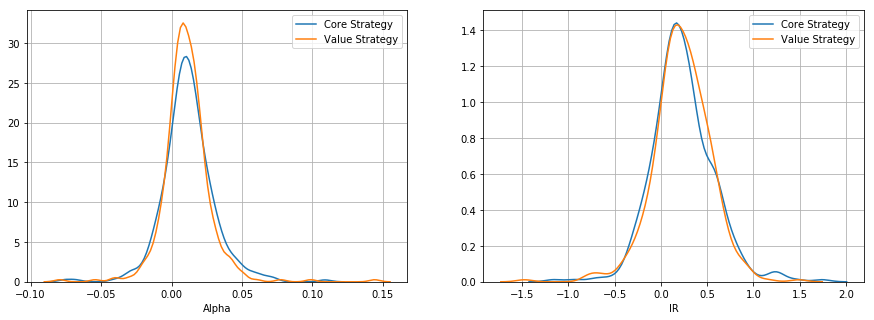

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(eVFunds_stats.loc[eVFunds_stats.Type=='USLargeCore', 'Alpha'], label='Core Strategy', hist= False)
sns.distplot(eVFunds_stats.loc[eVFunds_stats.Type=='USLargeValue', 'Alpha'], label= 'Value Strategy', hist=False)
# sns.distplot(eVFunds_stats.loc[eVFunds_stats.Type=='USLargeGrowth', 'Alpha'],label='Growth', hist= False)
plt.legend()
plt.grid()
plt.subplot(1,2,2)
sns.distplot(eVFunds_stats.loc[eVFunds_stats.Type=='USLargeCore', 'IR'], label='Core Strategy', hist= False)
sns.distplot(eVFunds_stats.loc[eVFunds_stats.Type=='USLargeValue', 'IR'], label= 'Value Strategy', hist=False)
# sns.distplot(eVFunds_stats.loc[eVFunds_stats.Type=='USLargeGrowth', 'Alpha'],label='Growth', hist= False)
plt.legend()
plt.grid()



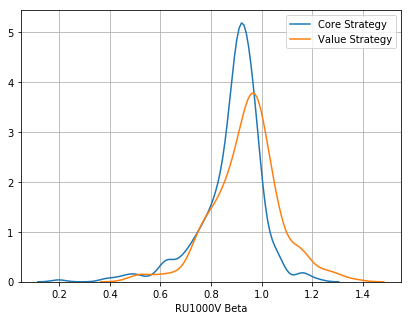

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(eVFunds_beta.loc[np.logical_and( eVFunds_beta.Type=='USLargeCore', eVFunds_beta.BenchmarkCond=='Overall'), 'RU1000VTR'], label='Core Strategy', hist= False)
sns.distplot(eVFunds_beta.loc[np.logical_and( eVFunds_beta.Type=='USLargeValue', eVFunds_beta.BenchmarkCond=='Overall'), 'RU1000VTR'], label='Value Strategy', hist= False)
plt.legend()
plt.xlabel('RU1000V Beta')
plt.grid()
# plt.subplot(1,2,2)
# sns.distplot(eVFunds_beta.loc[np.logical_and( eVFunds_beta.Type=='USLargeCore', eVFunds_beta.BenchmarkCond=='Overall'), 'Value_Prem'], label='Core Strategy', hist= False)
# sns.distplot(eVFunds_beta.loc[np.logical_and( eVFunds_beta.Type=='USLargeValue', eVFunds_beta.BenchmarkCond=='Overall'), 'Value_Prem'], label='Value Strategy', hist= False)
# plt.legend()
# plt.xlabel('Value Premium Beta')
# plt.grid()

Text(0,0.5,'RU1000V Beta')

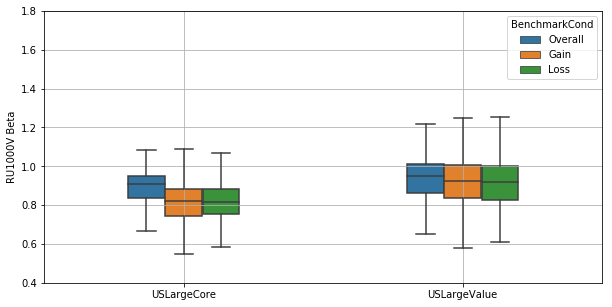

In [11]:
ax= plt.figure(figsize= (10,5))
d= eVFunds_beta.loc[[x in ('USLargeCore', 'USLargeValue') for x in eVFunds_beta.Type], ]
sns.boxplot(x='Type', y='RU1000VTR', hue='BenchmarkCond', width=0.4,
            data= d, fliersize=0)
plt.grid()
plt.ylim((0.4, 1.8))
plt.xlabel('')
plt.ylabel('RU1000V Beta')

In [12]:
# ax= plt.figure(figsize= (10,5))
# d= eVFunds_beta.loc[[x in ('USLargeCore', 'USLargeValue') for x in eVFunds_beta.Type], ]
# sns.boxplot(x='Type', y='Value_Prem', hue='BenchmarkCond', width=0.4,
#             data= d, fliersize=0)
# plt.grid()
# plt.ylim((-1.2, 2))
# plt.xlabel('')
# plt.ylabel('Value Premium Beta')

In [13]:
eVFunds_beta.groupby( ['Type', 'BenchmarkCond']).median()

NObs  RU1000VTR     const
Type                BenchmarkCond                            
USLargeCore         Gain           120.5   0.819340  0.004913
                    Loss            57.0   0.817224 -0.003487
                    Overall        174.5   0.909130  0.001613
USLargeCore_INDEX   Gain           197.5   0.826306  0.004837
                    Loss           100.0   0.845957 -0.003124
                    Overall        297.5   0.940866  0.000565
USLargeGrowth       Gain           144.0   0.719815  0.010179
                    Loss            85.0   0.724246 -0.009133
                    Overall        228.5   0.895111  0.001956
USLargeGrowth_INDEX Gain           257.0   0.738116  0.011185
                    Loss           136.0   0.766090 -0.012947
                    Overall        393.0   0.962162  0.000366
USLargeValue        Gain           123.0   0.926267  0.002168
                    Loss            59.0   0.919485 -0.000068
                    Overall        180.0   0.950013  0.001181
USLargeValue_INDEX  Gain           257.0   0.871984  0.003559
                    Loss           136.0   0.877229 -0.001364
                    Overall        393.0   0.969555  0.000229

In [14]:
eVFunds_stats.groupby('Type').median()

IR     Alpha        TE
Type                                             
USLargeCore          0.203380  0.011273  0.053304
USLargeCore_INDEX   -0.008900 -0.000440  0.050268
USLargeGrowth        0.147870  0.012721  0.085401
USLargeGrowth_INDEX -0.023798 -0.002200  0.092249
USLargeValue         0.230760  0.009837  0.045895
USLargeValue_INDEX  -0.056062 -0.003806  0.048245